In [69]:
import os
import SimpleITK as sitk
import numpy as np
from monai.data.image_reader import nib

In [96]:
def calculate_bounding_box(label_array):
    # 计算每个维度的非零值的最小和最大索引，并返回跨度
    positions = np.where(label_array != 0)
    bbox = []
    for dim in range(label_array.ndim):
        min_dim = np.min(positions[dim])
        max_dim = np.max(positions[dim])
        bbox.append((min_dim, max_dim, max_dim - min_dim + 1))
    return bbox

def calculate_center(bbox):
    # 根据bounding box计算中心点
    center = [(dim[0] + dim[1]) // 2 for dim in bbox]
    return center

def crop_image(image_array, center, bbox_size):
    # 根据中心点和bounding box大小裁剪图像
    start = [max(0, c - s//2) for c, s in zip(center, bbox_size)]
    end = [min(d, c + s//2) for c, s, d in zip(center, bbox_size, image_array.shape)]
    return image_array[start[0]:end[0], start[1]:end[1], start[2]:end[2]]

In [100]:
# 设置文件夹路径和参数
data_root = 'F:/DATASET/nnUNet_raw/Dataset220_KiTS2019'  # 替换为数据根目录路径
output_root = 'F:/DATASET/nnUNet_raw/Cropped_Dataset220_KiTS2019'  # 替换为输出根目录路径
# data_root = '../demo_data2'  # 替换为数据根目录路径
# output_root = '../demo_data2'  # 替换为输出根目录路径
# train_val_seg_index = 178

In [101]:


image_dir = os.path.join(data_root, "imagesTr/Train")# 替换为图像文件夹路径
label_dir = os.path.join(data_root, "labelsTr/Train")  # 替换为标签文件夹路径

image_output_dir = os.path.join(output_root, 'imagesTr_cropped/train')  # 替换为输出文件夹路径
label_output_dir = os.path.join(output_root, 'labelsTr_cropped/train')  # 替换为输出文件夹路径

In [102]:
# 确保输出目录存在
os.makedirs(image_output_dir, exist_ok=True)
os.makedirs(label_output_dir, exist_ok=True)

# 获取图像和标签文件列表
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.nii.gz')]
label_files = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.nii.gz')]

## 只切割train的，valid 和 test的不切割

In [103]:
# image_files = image_files[:train_val_seg_index]
# label_files = label_files[:train_val_seg_index]
print(len(image_files)/209)
print(len(label_files)/209)

0.8516746411483254
0.8516746411483254


In [104]:
from tqdm import tqdm
bbox_sizes = [0, 0, 0]  # 每个维度的最大跨度
    
# 计算全局最大跨度
for label_path in tqdm(label_files):
    label_img = nib.load(label_path)
    label_data = label_img.get_fdata()
    bbox = calculate_bounding_box(label_data)
    for i in range(3):
        bbox_sizes[i] = max(bbox_sizes[i], bbox[i][2])

# 扩张边界框大小- 留margin
bbox_sizes = [s + 6 for s in bbox_sizes]
bbox_sizes

[340, 221, 373]

In [105]:
from tqdm import tqdm

for image_path, label_path in tqdm(zip(image_files, label_files)):
        image_img = nib.load(image_path)
        image_data = image_img.get_fdata()
        label_img = nib.load(label_path)
        label_data = label_img.get_fdata()

        bbox = calculate_bounding_box(label_data)
        center = calculate_center(bbox)
        cropped_image = crop_image(image_data, center, bbox_sizes)
        cropped_label = crop_image(label_data, center, bbox_sizes)

        # 保存裁剪后的图像和标签
        cropped_image_nii = nib.Nifti1Image(cropped_image, affine=image_img.affine)
        cropped_label_nii = nib.Nifti1Image(cropped_label, affine=label_img.affine)
        nib.save(cropped_image_nii, os.path.join(image_output_dir, os.path.basename(image_path)))
        nib.save(cropped_label_nii, os.path.join(label_output_dir, os.path.basename(label_path)))

178it [10:26,  3.52s/it]


original_data shape: (602, 512, 512)
data.shape: (340, 220, 372)


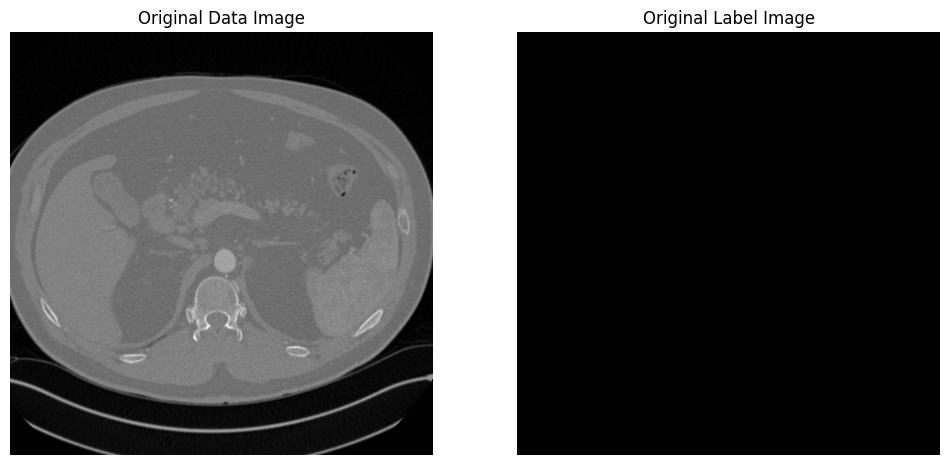

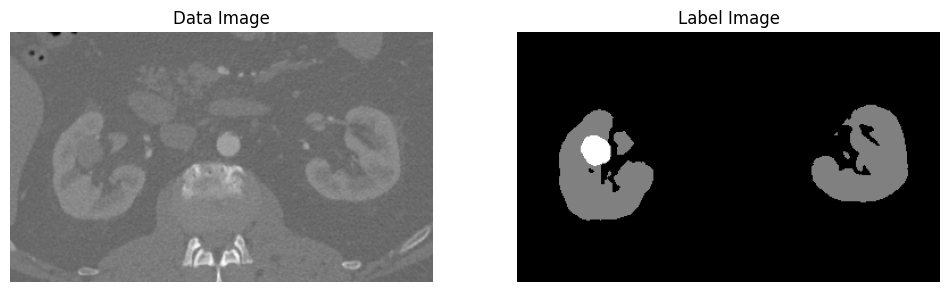

In [106]:
from monai.data.image_reader import nib
import matplotlib.pyplot as plt

case = 1
index = 150

original_data = nib.load(os.path.join(data_root, f'imagesTr/case_0000{case}_0000.nii.gz')).get_fdata()
original_label = nib.load(os.path.join(data_root, f'labelsTr/case_0000{case}.nii.gz')).get_fdata()
# 读取裁剪后的图像和标签
data = nib.load(os.path.join(output_root,f'imagesTr_cropped/train/case_0000{case}_0000.nii.gz')).get_fdata()
label = nib.load(os.path.join(output_root, f'labelsTr_cropped/train/case_0000{case}.nii.gz')).get_fdata()
# 打印裁剪后的图像和标签
print("original_data shape:", original_data.shape)
# print(data.shape)
print("data.shape:", data.shape)


plt.figure(figsize=(12, 6))  # 设置图形的总尺寸

# 显示原始数据图像
plt.subplot(1, 2, 1)  # 创建子图1（1行2列的第1个）
plt.imshow(original_data[index, :, :], cmap='gray')  # data[0, :, :] 表示选择第一切片
plt.title('Original Data Image')  # 子图标题
plt.axis('off')  # 不显示坐标轴

# 显示原始标签图像
plt.subplot(1, 2, 2)  # 创建子图2（1行2列的第2个）
plt.imshow(original_label[index, :, :], cmap='gray')  # label[0, :, :] 同上
plt.title('Original Label Image')  # 子图标题
plt.axis('off')  # 不显示坐标轴

plt.show()  # 显示图形



plt.figure(figsize=(12, 6))  # 设置图形的总尺寸

# 显示数据图像
plt.subplot(1, 2, 1)  # 创建子图1（1行2列的第1个）
plt.imshow(data[index, :, :], cmap='gray')  # data[0, :, :] 表示选择第一切片
plt.title('Data Image')  # 子图标题
plt.axis('off')  # 不显示坐标轴

# 显示标签图像
plt.subplot(1, 2, 2)  # 创建子图2（1行2列的第2个）
plt.imshow(label[index, :, :], cmap='gray')  # label[0, :, :] 同上
plt.title('Label Image')  # 子图标题
plt.axis('off')  # 不显示坐标轴

plt.show()  # 显示图形



In [109]:
def verify_cropping(image_dir, label_dir):
    image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.nii.gz')]
    label_files = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.nii.gz')]

    for image_path, label_path in tqdm(zip(image_files, label_files)):
        image = sitk.ReadImage(image_path)
        label = sitk.ReadImage(label_path)

        # 获取图像和标签的尺寸
        image_size = image.GetSize()
        label_size = label.GetSize()

        # 检查尺寸是否一致
        if image_size != label_size:
            print(f"Size mismatch for {os.path.basename(image_path)}: Image size {image_size}, label size {label_size}")

        # 检查标签中非零值是否在边缘
        label_array = sitk.GetArrayFromImage(label)
        non_zero_indices = np.nonzero(label_array)
        bounds = [(min(idx), max(idx)) for idx in non_zero_indices]
        at_edge = any(min_idx == 0 or max_idx == sz - 1 for (min_idx, max_idx), sz in zip(bounds, label_size))

        if at_edge:
            print(f"Non-zero label values at edge for {os.path.basename(label_path)}")
    
    print("Cropping verification completed. All good")

# 使用这个函数来检查剪切后的图像和标签
verify_cropping(image_output_dir, label_output_dir)  # 假设输出图像和标签位于同一目录

178it [03:31,  1.19s/it]

Cropping verification completed. All good
